In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader, random_split
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

In [3]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.global_avg_pool(x))
        max_out = self.fc(self.global_max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

In [4]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

In [5]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)  # Apply channel attention
        x = x * self.spatial_attention(x)  # Apply spatial attention
        return x

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        # Generate query, key, and value matrices
        query = self.query_conv(x).view(batch_size, C, -1)  # (B, C, W*H)
        key = self.key_conv(x).view(batch_size, C, -1)      # (B, C, W*H)
        value = self.value_conv(x).view(batch_size, C, -1)  # (B, C, W*H)

        # Compute attention scores
        scores = F.softmax(torch.bmm(query.transpose(1, 2), key), dim=-1)  # (B, W*H, W*H)

        # Compute the attention-weighted values
        out = torch.bmm(value, scores.transpose(1, 2))  # (B, C, W*H)
        out = out.view(batch_size, C, width, height)    # Reshape to (B, C, W, H)

        # Apply residual connection and scaling
        return self.gamma * out + x

In [7]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ConvolutionalAutoEncoder, self).__init__()
        #Conv1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.CBAM1 = CBAM(16,16,7)

        #Conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.CBAM2 = CBAM(32,32,7)

        #Conv3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.CBAM3 = CBAM(32,32,7)

        #Conv4
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,dilation = 2, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.CBAM4 = CBAM(64,64,7)

        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.selfattn = SelfAttention(64)

        #Deconv1
        self.conv1Trans = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3,dilation = 2, stride=1, padding=0)
        self.bn1Trans = nn.BatchNorm2d(32)
        self.dropout1Trans = nn.Dropout(dropout_rate)

        #Deconv2
        self.conv2Trans = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn2Trans = nn.BatchNorm2d(32)
        self.dropout2Trans = nn.Dropout(dropout_rate)

        #Deconv3
        self.conv3Trans = nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.bn3Trans = nn.BatchNorm2d(16)
        self.dropout3Trans = nn.Dropout(dropout_rate)

        #Deconv4
        self.conv4Trans = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=0)

        #Deconv5
        self.convoutput = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.maxUnpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
    # Encoder
      x = self.ReLU(self.bn1(self.conv1(x)))
      x = self.dropout1(x)
      x = self.CBAM1(x)
      conv_1 = x.clone()
      x, idx_1 = self.maxPool(x)

      x = self.ReLU(self.bn2(self.conv2(x)))
      x = self.dropout2(x)
      x = self.CBAM2(x)
      conv_2 = x.clone()
      x, idx_2 = self.maxPool(x)

      x = self.ReLU(self.bn3(self.conv3(x)))
      x = self.dropout3(x)
      x = self.CBAM3(x)
      conv_3 = x.clone()
      x, idx_3 = self.maxPool(x)

      x = self.ReLU(self.bn4(self.conv4(x)))
      x = self.dropout4(x)
      x = self.CBAM4(x)
      conv_4 = x.clone()
      x, idx_4 = self.maxPool(x)

      x = self.selfattn(x)

    # Decoder
      x = self.maxUnpool(x, idx_4,output_size = conv_4.size())
      concat = torch.concat((x,conv_4.clone()),dim = 1)
      x = self.ReLU(self.bn1Trans(self.conv1Trans(concat)))
      x = self.dropout1Trans(x)

      x = self.maxUnpool(x, idx_3,output_size = conv_3.size())
      concat = torch.concat((x,conv_3.clone()),dim = 1)
      x = self.ReLU(self.bn2Trans(self.conv2Trans(concat)))
      x = self.dropout2Trans(x)

      x = self.maxUnpool(x, idx_2,output_size = conv_2.size())
      concat = torch.concat((x,conv_2.clone()),dim = 1)
      x = self.ReLU(self.bn3Trans(self.conv3Trans(concat)))
      x = self.dropout3Trans(x)

      x = self.maxUnpool(x, idx_1,output_size = conv_1.size())
      concat = torch.concat((x,conv_1.clone()),dim = 1)
      x = self.ReLU(self.conv4Trans(concat))
      x = self.sigmoid(self.convoutput(x))

      return x

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, img_folder, label_folder, transform=None):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_paths = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_paths = [os.path.join(label_folder, f) for f in os.listdir(label_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Ensure the lengths match
        assert len(self.image_paths) == len(self.label_paths), "Number of images and labels must match."

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = Image.open(self.label_paths[idx])

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

In [9]:
import os

def find_unmatched_files(img_folder, label_folder):
    # Get filenames without extensions for images and labels
    img_files = set(os.path.splitext(f)[0] for f in os.listdir(img_folder) if f.endswith(('.png', '.jpg', '.jpeg')))
    label_files = set(os.path.splitext(f)[0] for f in os.listdir(label_folder) if f.endswith(('.png', '.jpg', '.jpeg')))

    # Find unmatched files
    unmatched_img_files = img_files - label_files  # Images without labels
    unmatched_label_files = label_files - img_files  # Labels without images

    # List the unmatched file paths
    unmatched_img_paths = [os.path.join(img_folder, f + ext) for f in unmatched_img_files for ext in ['.png', '.jpg', '.jpeg'] if os.path.exists(os.path.join(img_folder, f + ext))]
    unmatched_label_paths = [os.path.join(label_folder, f + ext) for f in unmatched_label_files for ext in ['.png', '.jpg', '.jpeg'] if os.path.exists(os.path.join(label_folder, f + ext))]

    return unmatched_img_paths, unmatched_label_paths

# Example usage
img_folder = r"/data2/Gadha/Denoising_DIV2K_1/train/input"  # Replace with your image folder path
label_folder = r"/data2/Gadha/Denoising_DIV2K_1/train/target"  # Replace with your label folder path

unmatched_img_paths, unmatched_label_paths = find_unmatched_files(img_folder, label_folder)
print(len(os.listdir(label_folder))+1)
print("Unmatched images:", unmatched_img_paths)
print("Unmatched labels:", unmatched_label_paths)


933
Unmatched images: []
Unmatched labels: []


In [10]:
# Example usage
img_folder = r"/data2/Gadha/Denoising_DIV2K_1/train/input"  # Replace with your image folder path
label_folder = r"/data2/Gadha/Denoising_DIV2K_1/train/target"  # Replace with your label folder path

# Define any transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])


from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.size(0) == 1 else x)  # Expand to 3 channels if grayscale
])

# Create the dataset
dataset = CustomImageDataset(img_folder, label_folder, transform=transform)




In [11]:
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
val_img_noisy = Image.open(r"/data2/Gadha/Denoising_DIV2K/train/input/000_contamination_pill.png")
val_img_true = Image.open(r"/data2/Gadha/Denoising_DIV2K/train/target/000_contamination_pill.png")
trfm = transforms.ToTensor()
val_img_noisy = trfm(val_img_noisy)
val_img_true = trfm(val_img_true)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_img_noisy = val_img_noisy.to(device)
val_img_true = val_img_true.to(device)

In [15]:
def calculate_psnr(original, compressed):
    # Ensure the images are in the range [0, 1]
    original = original.clamp(0, 1)  # Clamping to handle potential out-of-bounds values
    compressed = compressed.clamp(0, 1)

    mse = torch.mean((original - compressed) ** 2)
    if mse == 0:  # If there's no difference, PSNR is infinite
        return float('inf')

    max_pixel = 1.0  # For normalized images
    psnr = 10 * torch.log10(max_pixel**2 / mse)
    return psnr

In [65]:
def calculate_ssim(img1, img2,win_size = 3):
    # Ensure the images are in the correct format
    img1 = img1.cpu().detach().numpy().squeeze()  # Convert to NumPy and remove batch/dimensions if necessary
    img2 = img2.cpu().detach().numpy().squeeze()

    # Normalize the images to the range [0, 1]
    img1 = (img1 - img1.min()) / (img1.max() - img1.min())
    img2 = (img2 - img2.min()) / (img2.max() - img2.min())

    ssim_values = []
    for c in range(img1.shape[0]):  # Iterate over each channel
        channel_ssim = ssim(img1[c], img2[c], data_range=img2[c].max() - img2[c].min(), win_size=win_size)
        ssim_values.append(channel_ssim)

    # Return the average SSIM across channels
    return np.mean(ssim_values)

In [17]:
def test_model(model):
    model.eval()
    with torch.no_grad():
        recon_img = model(val_img_noisy.unsqueeze(dim = 0))
    return recon_img

In [ ]:
def train_model_conv(model,dataloader,optimiser,criterion,num_epochs,vgg_regulariser):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    model.train()
    # vgg_feature_extractor = VGG19FeatureExtractor().to(device)
    # vgg_feature_extractor.eval()

    for epochs in range(1,num_epochs + 1):
        train_loss = 0
        p_loss = 0
        r_loss = 0
        s_loss = 0
        for batch,labels in dataloader:
            batch,labels = batch.to(device),labels.to(device)
            gaussian_noise = (torch.randn(batch.shape)*0.1).to(device)
            batch = batch + gaussian_noise
            reconstructed_X = model(batch)
            optimiser.zero_grad()

            recon_loss = criterion(reconstructed_X,labels)
            r_loss += recon_loss.item()

           
            total_loss = recon_loss #+ vgg_regulariser*perceptual_loss
            total_loss.backward()
            optimiser.step()

            train_loss += total_loss.item()
        recon_img = test_model(model)
        psnr = calculate_psnr(val_img_true.unsqueeze(dim = 0),recon_img)
        ssim = calculate_ssim(recon_img,val_img_true.unsqueeze(dim = 0))
        model.train()

        print(f"Epoch [{epochs}/{num_epochs}] || training_loss: {train_loss:.4f} || P_loss: {1} || r_loss: {r_loss:.4f} || PSNR: {psnr:.4f} || SSIM: {ssim:.4f}")

In [19]:
ConvAE = ConvolutionalAutoEncoder(dropout_rate = 0.4)
criterionConvAE = nn.L1Loss()
optimiserConvAE = optim.Adam(ConvAE.parameters(),lr = 0.0005)

In [20]:
cd /data2


/data2


In [21]:
import os
from PIL import Image

def find_images_with_invalid_size(folder_path, target_size=(700, 700)):
    # List to hold paths and sizes of images with invalid dimensions
    invalid_images = []

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            with Image.open(image_path) as img:
                # Check the image size and number of channels
                if img.size != target_size or len(img.getbands()) != 3:
                    invalid_images.append((image_path, img.size))

    return invalid_images

# Example usage
folder_path = r"/data2/Gadha/Denoising_DIV2K_1/train/input"  # Replace with your folder path
invalid_images = find_images_with_invalid_size(folder_path)

# Print the invalid image paths and their sizes
if invalid_images:
    print("Images with invalid dimensions:")
    for img_path, img_size in invalid_images:
        print(f"{img_path.split('/')[6]}: {img_size}")
else:
    print("All images have the correct dimensions.")


All images have the correct dimensions.


In [22]:
train_model_conv(ConvAE,dataloader,optimiserConvAE,criterionConvAE,50,0.5)

cuda
Epoch [1/50] || training_loss: 31.6726 || P_loss: 1 || r_loss: 31.6726 || PSNR: 17.4722 || SSIM: 0.5026
Epoch [2/50] || training_loss: 25.4812 || P_loss: 1 || r_loss: 25.4812 || PSNR: 17.7949 || SSIM: 0.5493
Epoch [3/50] || training_loss: 23.1749 || P_loss: 1 || r_loss: 23.1749 || PSNR: 23.5932 || SSIM: 0.6511
Epoch [4/50] || training_loss: 15.9677 || P_loss: 1 || r_loss: 15.9677 || PSNR: 21.8397 || SSIM: 0.6404
Epoch [5/50] || training_loss: 15.0514 || P_loss: 1 || r_loss: 15.0514 || PSNR: 22.3994 || SSIM: 0.6563
Epoch [6/50] || training_loss: 14.2450 || P_loss: 1 || r_loss: 14.2450 || PSNR: 22.8087 || SSIM: 0.6824
Epoch [7/50] || training_loss: 14.0645 || P_loss: 1 || r_loss: 14.0645 || PSNR: 24.3740 || SSIM: 0.6995
Epoch [8/50] || training_loss: 13.8161 || P_loss: 1 || r_loss: 13.8161 || PSNR: 25.2332 || SSIM: 0.7242
Epoch [9/50] || training_loss: 13.3651 || P_loss: 1 || r_loss: 13.3651 || PSNR: 24.0862 || SSIM: 0.7164
Epoch [10/50] || training_loss: 13.3366 || P_loss: 1 || r_l

In [30]:
val2 = Image.open(r"/data2/Gadha/Denoising_DIV2K_1/test/input/006_bent_grid.png")
trfm = transforms.ToTensor()
val2 = trfm(val2)

In [ ]:
val3 = Image.open(r"/data2/Gadha/Denoising_DIV2K_1/test/input/007_color_wood.png")
trfm = transforms.ToTensor()
val3 = trfm(val3)

In [ ]:
val2 = val2.to(device)
val3 = val3.to(device)

In [ ]:
ConvAE.eval()
with torch.no_grad():
  recon = ConvAE(val2.unsqueeze(dim = 0))
  recon_3 = ConvAE(val3.unsqueeze(dim = 0))

In [ ]:
recon = recon.to('cpu')
recon.shape

recon_3 = recon_3.to('cpu')
recon_3.shape



torch.Size([1, 3, 700, 700])

In [36]:
import cv2

(-0.5, 699.5, 699.5, -0.5)

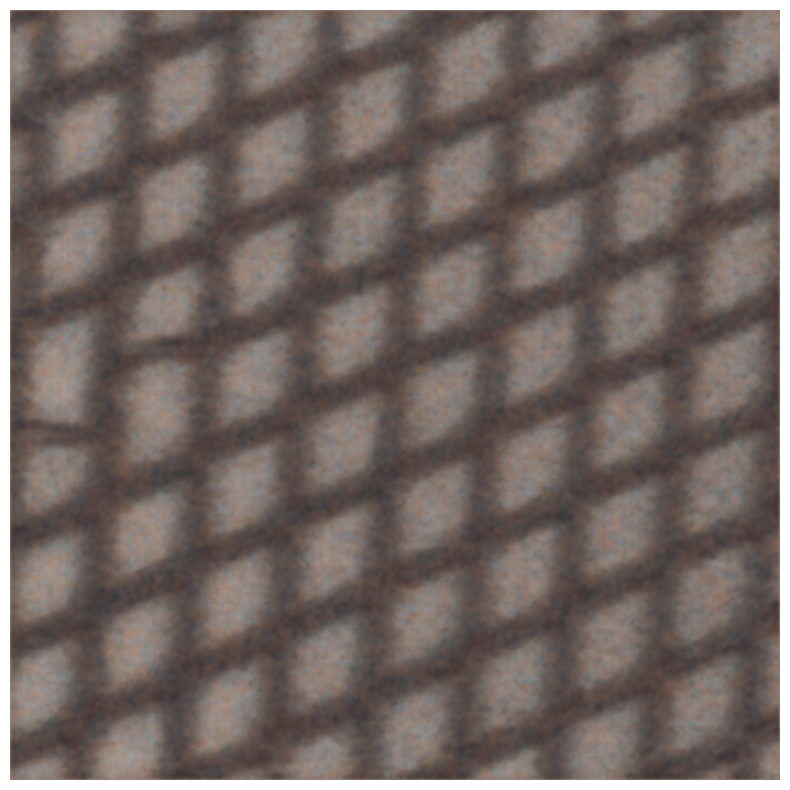

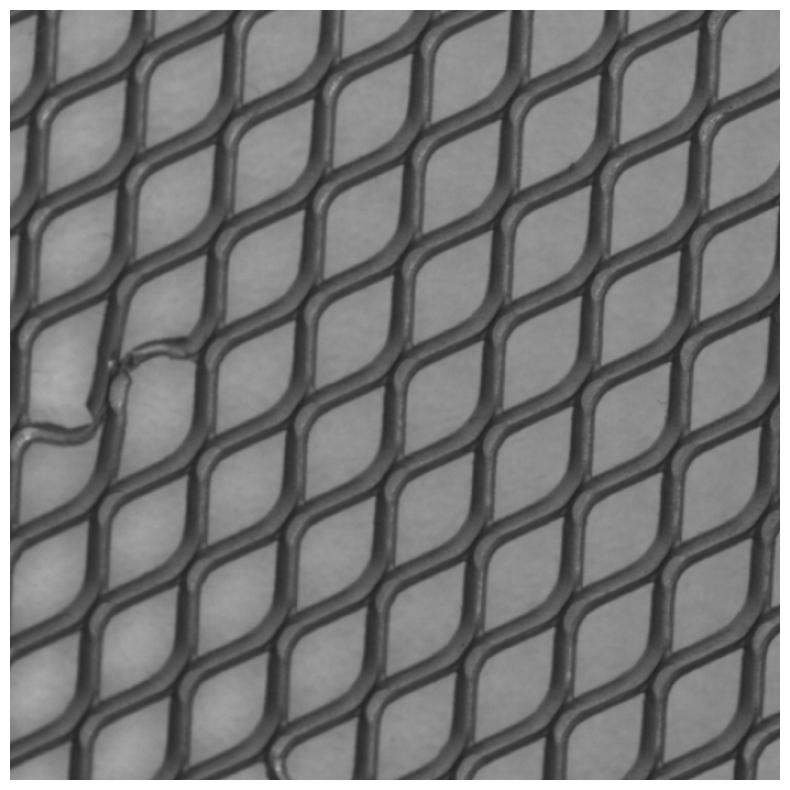

In [39]:
plt.figure(figsize =  (10,10))
plt.imshow(recon.squeeze().permute(1,2,0).detach().numpy())
plt.axis("off")
recon_tar = cv2.imread('/data2/Gadha/Denoising_DIV2K_1/test/target/006_bent_grid.png')
plt.figure(figsize =  (10,10))
plt.imshow(recon_tar)
plt.axis("off")

# plt.figure(figsize =  (10,10))
# plt.imshow(recon.squeeze().permute(1,2,0).detach().numpy())
# plt.axis("off")

# plt.figure(figsize =  (10,10))
# plt.imshow(recon.squeeze().permute(1,2,0).detach().numpy())
# plt.axis("off")



In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import math


def calculate_psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')  
    psnr = 20 * math.log10(1.0 / math.sqrt(mse.item()))  
    return psnr


transform = transforms.ToTensor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
psnr_values = []
ssim_vals = []

ConvAE.eval()


input_dir = "/data2/Gadha/Denoising_DIV2K/test/input"
target_dir = "/data2/Gadha/Denoising_DIV2K/test/target"


with torch.no_grad():
    for img_name in os.listdir(input_dir):
        input_path = os.path.join(input_dir, img_name)
        target_path = os.path.join(target_dir, img_name)  
        
        
        input_image = Image.open(input_path)
        target_image = Image.open(target_path)
        if target_image.mode != 'RGB':
            target_image = target_image.convert('RGB')
        
        input_tensor = transform(input_image).to(device)
        target_tensor = transform(target_image).to(device)
        
        
        reconstructed = ConvAE(input_tensor.unsqueeze(0))
        reconstructed = reconstructed.squeeze(0).cpu() 
        
        
        psnr = calculate_psnr(target_tensor.cpu(), reconstructed)
        SSIM = calculate_ssim(target_tensor.cpu(),reconstructed)
        psnr_values.append(psnr)
        ssim_vals.append(SSIM)
        
        print(f"For {img_name}: PSNR: {psnr:.2f} dB, SSIM: {SSIM:.2f}")


average_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_vals)
print(f"\nAverage PSNR over the test dataset: {average_psnr:.2f} dB")
print(f"\nAverage SSIM over the test dataset: {avg_ssim:.2f}")


For 006_bent_grid.png: PSNR: 20.53 dB, SSIM: 0.50
For 008_liquid_wood.png: PSNR: 26.36 dB, SSIM: 0.36
For 007_missing_wire_cable.png: PSNR: 21.12 dB, SSIM: 0.76
For 007_cable_swap_cable.png: PSNR: 20.26 dB, SSIM: 0.77
For 008_hole_wood.png: PSNR: 25.30 dB, SSIM: 0.41
For 008_poke_insulation_cable.png: PSNR: 21.23 dB, SSIM: 0.76
For 008_misplaced_transistor.png: PSNR: 24.42 dB, SSIM: 0.78
For 007_metal_contamination_grid.png: PSNR: 23.18 dB, SSIM: 0.52
For 006_pill_type_pill.png: PSNR: 21.42 dB, SSIM: 0.70
For 006_broken_grid.png: PSNR: 23.66 dB, SSIM: 0.57
For 007_hole_carpet.png: PSNR: 18.56 dB, SSIM: 0.38
For 007_color_wood.png: PSNR: 23.09 dB, SSIM: 0.33
For 008_cut_outer_insulation_cable.png: PSNR: 20.38 dB, SSIM: 0.73
For 007_thread_carpet.png: PSNR: 19.05 dB, SSIM: 0.42
For 007_split_teeth_zipper.png: PSNR: 19.07 dB, SSIM: 0.69
For 008_rough_tile.png: PSNR: 20.51 dB, SSIM: 0.51
For 005_thread_top_screw.png: PSNR: 21.65 dB, SSIM: 0.74
For 006_glue_grid.png: PSNR: 21.13 dB, SSIM: 0

In [ ]:

torch.save(ConvAE.state_dict(), "/data2/Gadha/ConvAE_weights.pth")
print("Model weights saved as ConvAE_weights.pth")


Model weights saved as ConvAE_weights.pth
